In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [3]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)

def getScore(x,y, model):
    predictions = model(x).numpy()
    y_p = predictions[:,0]
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)

def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

In [4]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './multi_level/fog_dataset_extend_multilevels.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6_v2.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_full.suf110.25_20.125_pre110.25_20.25_59754_201508-202205_72h1_168h6_v2.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fog_dataset_allstation.h5'))
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fog_dataset_hdf66_fc120h.h5'))
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [5]:
def customized_mes(y_true, y_pred): # 自定义均方差
    '''
    自定义均方差
    '''
    square = tf.square(y_pred - y_true)
    # y_true [0,1] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [0.2,0.5,1.5,3.0]
    mse_0_1   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*0.6, 
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*1.2,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*2.0,
                                                                      square*3.0)))
    # y_true [1,4/3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [1.0,0.5,1.0,3.0]
    mse_1_43  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*1.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*0.6,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*1.5,
                                                                      square*3.0)))
    # y_true [4/3,2] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [2.0,1.square
    mse_43_2  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*2.2,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*1.2,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*0.6,
                                                                      square*2.0)))
    # y_true [2,3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [3.0,2.0,1.0,0.5]
    mse_2_3   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*3.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*2.0,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*1.0,
                                                                      square*0.6)))
    sum = tf.where(tf.less_equal(y_true, tf.constant(1.0)),     mse_0_1,
          tf.where(tf.less_equal(y_true, tf.constant(4.0/3.0)), mse_1_43,
          tf.where(tf.less_equal(y_true, tf.constant(2.0)),     mse_43_2, 
                                                                mse_2_3)
          )
        )
    return tf.reduce_mean(sum)

In [6]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3,
                drop_out_layers = 2,
                drop_out_layers_size = 12,
                drop_out_rate = 0.5,):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', 
                                kernel_regularizer=regularizers.l2(0.0001),
                                input_shape=train_x.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))

    for _ in range(drop_out_layers - 1):
        model.add(keras.layers.Dense(drop_out_layers_size, activation = 'relu'))
        model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = customized_mes, optimizer = optimizer,metrics=["mean_squared_error",])
    return model

sklearn_model = KerasRegressor(build_fn = build_model)
# callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
# history = sklearn_model.fit(train_x_scaled, train_y,
#                             epochs = 50,
#                             validation_data = (valid_x_scaled, valid_y),
#                             callbacks = callbacks)

C:\Users\Henry\AppData\Local\Temp\ipykernel_19408\1293799354.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasRegressor(build_fn = build_model)


In [7]:
from scipy.stats import reciprocal

# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4, 5, 6, 7],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
    "drop_out_layers":[1, 2, 3, 4, 5, 6, 7],
    "drop_out_layers_size":np.arange(1, 100),
    "drop_out_rate":[0.4, 0.45, 0.5, 0.55, 0.6]
}
callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(train_x_scaled, train_y, epochs = 100,
                     validation_data = (valid_x_scaled, valid_y),
                     callbacks = callbacks)

Epoch 1/100
9777/9777 [==============================] - 49s 5ms/step - loss: 0.2868 - mean_squared_error: 0.2380 - val_loss: 0.3956 - val_mean_squared_error: 0.3059
Epoch 2/100
9777/9777 [==============================] - 50s 5ms/step - loss: 0.2253 - mean_squared_error: 0.1948 - val_loss: 0.3568 - val_mean_squared_error: 0.2876
Epoch 3/100
9777/9777 [==============================] - 50s 5ms/step - loss: 0.2107 - mean_squared_error: 0.1846 - val_loss: 0.5800 - val_mean_squared_error: 0.3858
Epoch 4/100
9777/9777 [==============================] - 51s 5ms/step - loss: 0.2027 - mean_squared_error: 0.1790 - val_loss: 0.3514 - val_mean_squared_error: 0.2738
Epoch 5/100
9777/9777 [==============================] - 49s 5ms/step - loss: 0.1971 - mean_squared_error: 0.1748 - val_loss: 0.4503 - val_mean_squared_error: 0.3262
Epoch 6/100
9777/9777 [==============================] - 50s 5ms/step - loss: 0.1924 - mean_squared_error: 0.1714 - val_loss: 0.4494 - val_mean_squared_error: 0.3234
Epoc

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021C3418E670>,
                   n_jobs=1,
                   param_distributions={'drop_out_layers': [1, 2, 3, 4, 5, 6,
                                                            7],
                                        'drop_out_layers_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 5...
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021C34895D60>})

In [8]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model = random_search_cv.best_estimator_.model
model.evaluate(test_x_scaled, test_y)
model.evaluate(valid_x_scaled, valid_y)

{'drop_out_layers': 2, 'drop_out_layers_size': 69, 'drop_out_rate': 0.4, 'hidden_layers': 3, 'layer_size': 31, 'learning_rate': 0.007466711758416702}
-0.15628622472286224
4190/4190 [==============================] - 10s 2ms/step - loss: 0.4554 - mean_squared_error: 0.3288


[0.45535194873809814, 0.328782320022583]

In [9]:
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = callbacks)

Epoch 1/50
14665/14665 [==============================] - 71s 5ms/step - loss: 0.1672 - mean_squared_error: 0.1506 - val_loss: 0.3756 - val_mean_squared_error: 0.2901
Epoch 2/50
14665/14665 [==============================] - 71s 5ms/step - loss: 0.1647 - mean_squared_error: 0.1490 - val_loss: 0.4391 - val_mean_squared_error: 0.3159
Epoch 3/50
14665/14665 [==============================] - 72s 5ms/step - loss: 0.1633 - mean_squared_error: 0.1475 - val_loss: 0.4219 - val_mean_squared_error: 0.3157
Epoch 4/50
14665/14665 [==============================] - 70s 5ms/step - loss: 0.1612 - mean_squared_error: 0.1461 - val_loss: 0.3985 - val_mean_squared_error: 0.3040
Epoch 5/50
14665/14665 [==============================] - 68s 5ms/step - loss: 0.1593 - mean_squared_error: 0.1447 - val_loss: 0.4035 - val_mean_squared_error: 0.2957
Epoch 6/50
14665/14665 [==============================] - 70s 5ms/step - loss: 0.1578 - mean_squared_error: 0.1435 - val_loss: 0.4141 - val_mean_squared_error: 0.305

In [33]:

# model_path = os.path.join(file_dir, './fulltime/model_0.818')
# tf.keras.models.save_model(
#     model, model_path, overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )
model_path = os.path.join(file_dir, './fulltime/fog_dataset_hdf66_fc120h')
tf.keras.models.save_model(
    model, model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: F:/github/pythonScript/seafog/data/collection/./fulltime/fog_dataset_hdf66_fc120h\assets


In [35]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 77)                1386      
                                                                 
 dense_211 (Dense)           (None, 77)                6006      
                                                                 
 dense_212 (Dense)           (None, 77)                6006      
                                                                 
 dense_213 (Dense)           (None, 77)                6006      
                                                                 
 dense_214 (Dense)           (None, 1)                 78        
                                                                 
Total params: 19,482
Trainable params: 19,482
Non-trainable params: 0
_________________________________________________________________


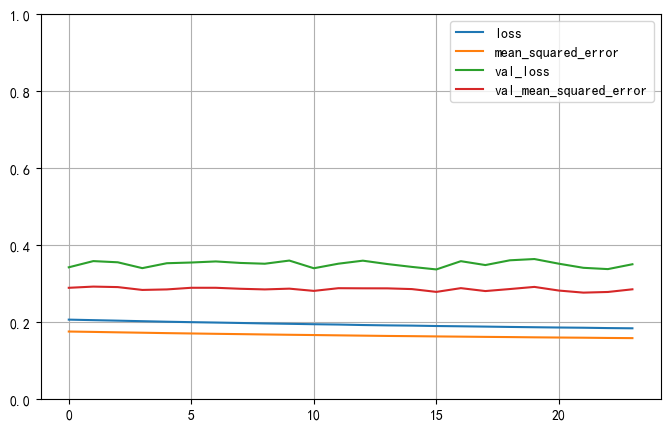

In [36]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [10]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[0.33810195326805115, 0.2512052357196808]

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3
* hp 搜索后MSE达到了0.245

In [11]:
def showPredictions(x, y, origin_vis, titlePrefix=''):
    print(f'模式评估损失函数{model.evaluate(x, y, verbose=0)}')
    predictions = model(x).numpy()
    plt.scatter(y, predictions[:,0], marker='.',  alpha=0.3)
    plt.title(f'{titlePrefix} 标准化能见度实况 VS 预报')
    plt.show()
    r,p = pearsonr(predictions[:,0],y)
    print(f'相关系数{r}, p值为{p:.5f}')

    plt.plot(origin_vis, np.vectorize(reverse_linear_vis)(predictions[:,0]) ,'.')
    plt.title(f'{titlePrefix} 能见度实况 VS 预报')
    plt.show()



模式评估损失函数[0.33810195326805115, 0.2512052357196808]


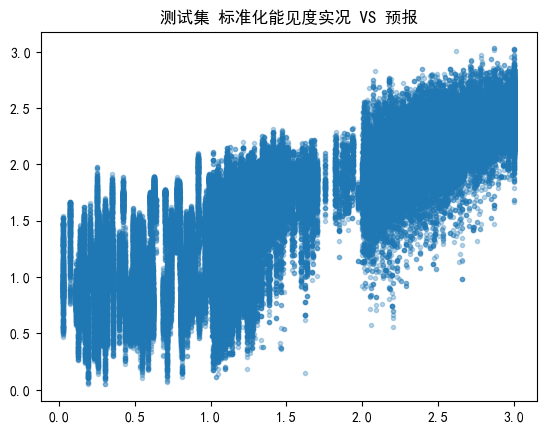

相关系数0.8186176493366983, p值为0.00000


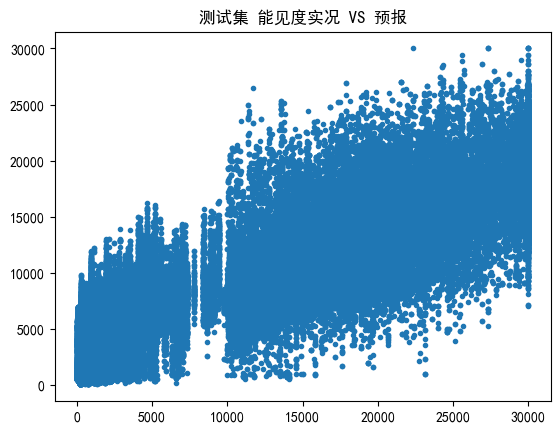

模式评估损失函数[0.37386924028396606, 0.27596572041511536]


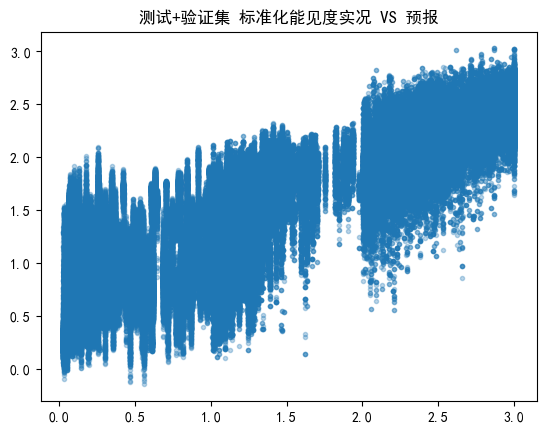

相关系数0.8255795077235759, p值为0.00000


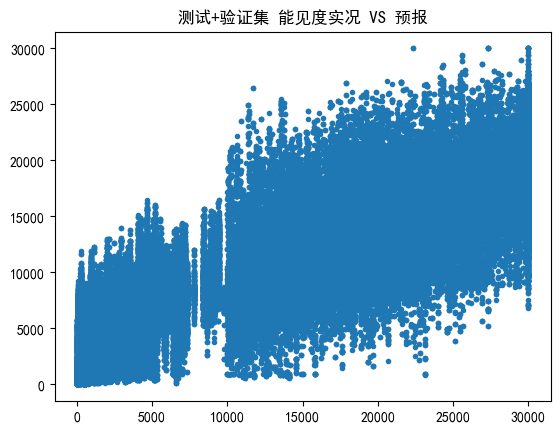

模式评估损失函数[0.1400948315858841, 0.12785376608371735]


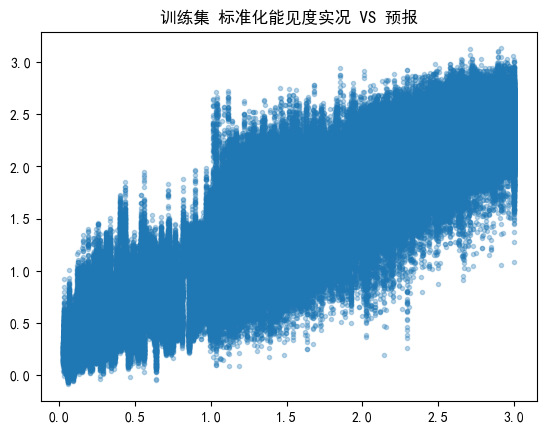

相关系数0.9141037269819594, p值为0.00000


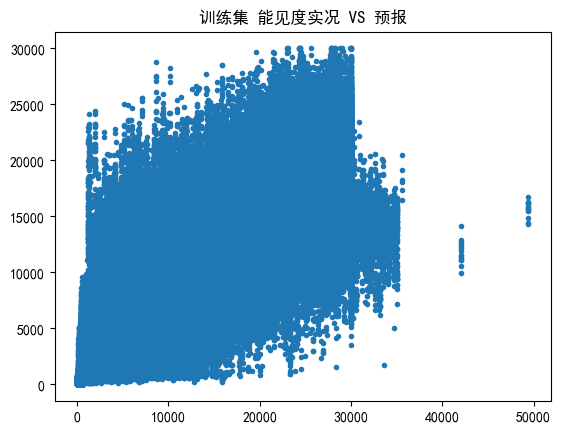

模式评估损失函数[0.4096393883228302, 0.3007265031337738]


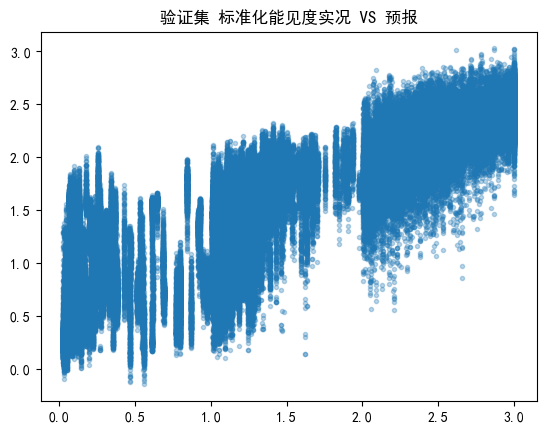

相关系数0.8301066931891485, p值为0.00000


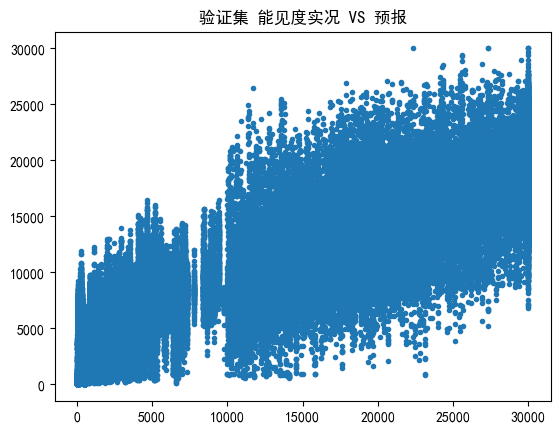

In [12]:
showPredictions(test_x_scaled, test_y, df_test['station_vis'].values, '测试集')
showPredictions(valid_test_x_scaled, valid_test_y, df_valid_test['station_vis'].values, '测试+验证集')
showPredictions(train_x_scaled, train_y, df_train['station_vis'].values, '训练集')
showPredictions(valid_x_scaled, valid_y, df_valid['station_vis'].values, '验证集')

In [13]:
print('=======================测试集==========')
getScore(test_x_scaled, test_y, model)
print('===================测试集+验证集==========')
getScore(valid_test_x_scaled, valid_test_y, model)
print('========================训练集==========')
getScore(train_x_scaled, train_y, model)
print('===================验证集==========')
getScore(valid_x_scaled, valid_y, model)

=======================测试集==========
* 实况为雾时: 比例: 雾:0.4359743136509073, 轻雾0.5625936947620432, 无雾0.001431991587049426
* 实况为轻雾时: 比例: 雾:0.1649699058018034, 轻雾0.7874834985344461, 无雾0.047546595663750475
* 实况为无雾时: 比例: 雾:0.0013201172443111898, 轻雾0.3383080124404269, 无雾0.6603718703152619
===================测试集+验证集==========
* 实况为雾时: 比例: 雾:0.5385019857917995, 轻雾0.460569446775186, 无雾0.0009285674330144879
* 实况为轻雾时: 比例: 雾:0.16529619063601275, 轻雾0.7869217430217598, 无雾0.047782066342227446
* 实况为无雾时: 比例: 雾:0.0013536946915030485, 轻雾0.3390501762040611, 无雾0.6595961291044359
========================训练集==========
* 实况为雾时: 比例: 雾:0.9012868951496903, 轻雾0.09871310485030974, 无雾0.0
* 实况为轻雾时: 比例: 雾:0.07062260664991721, 轻雾0.8330616341586595, 无雾0.09631575919142325
* 实况为无雾时: 比例: 雾:0.002461274876456787, 轻雾0.3715949700491616, 无雾0.6259437550743816
===================验证集==========
* 实况为雾时: 比例: 雾:0.6410319520272084, 轻雾0.35854291595811333, 无雾0.0004251320146782422
* 实况为轻雾时: 比例: 雾:0.16562248277096572, 轻雾0.7863599749395865, 无

[0.33941447734832764, 0.26220306754112244]


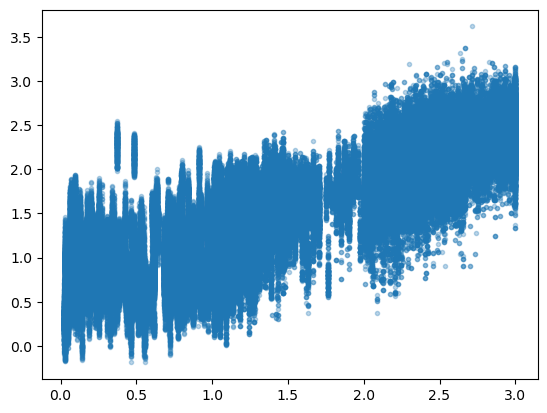

相关系数0.8201421724675368, p值为0.00000


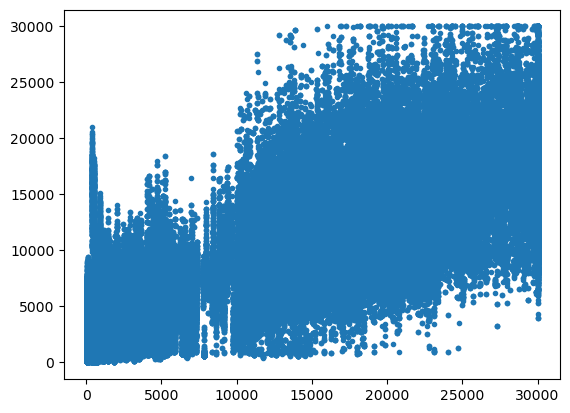

In [14]:
print(model.evaluate(test_x_scaled, test_y, verbose=0))
predictions = model(test_x_scaled).numpy()
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()
r,p = pearsonr(predictions[:,0],test_y)
print(f'相关系数{r}, p值为{p:.5f}')

plt.plot(df_test['station_vis'].values, np.vectorize(reverse_linear_vis)(predictions[:,0]) ,'.')
plt.show()

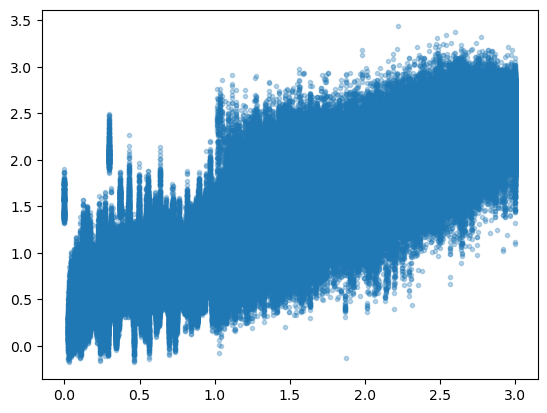

In [15]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

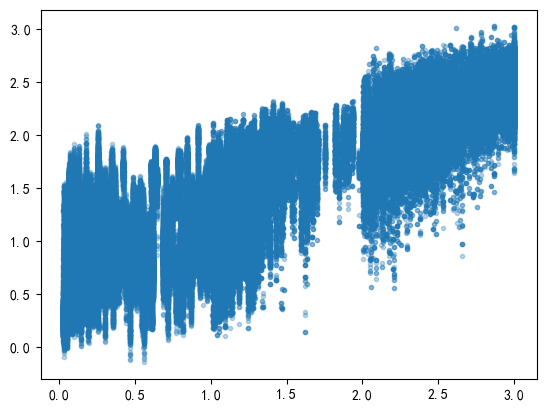

In [14]:
predictions = model(test_x_scaled).numpy()
valid_predictions = model(valid_x_scaled).numpy()
all_predictions = np.concatenate((predictions[:,0],valid_predictions[:,0]))
all_y = np.concatenate((test_y,valid_y))
plt.plot(all_y, all_predictions,'.', alpha=0.3)
plt.show()

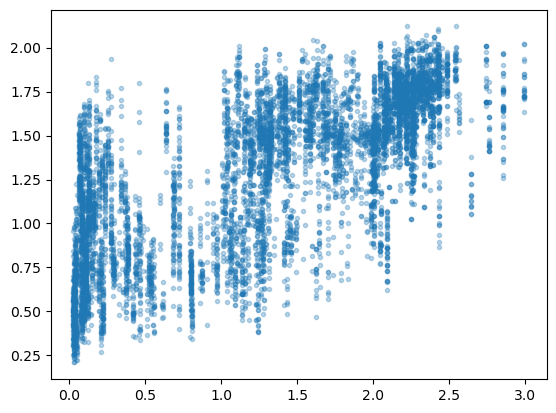

In [15]:
plt.plot(valid_y,model(valid_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

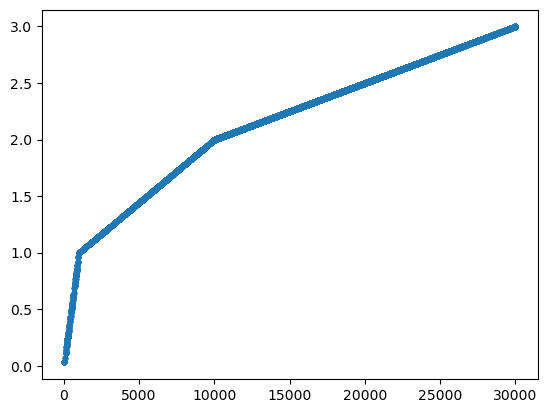

In [25]:
plt.plot(df_test['station_vis'].values,test_y,'.')
plt.show()

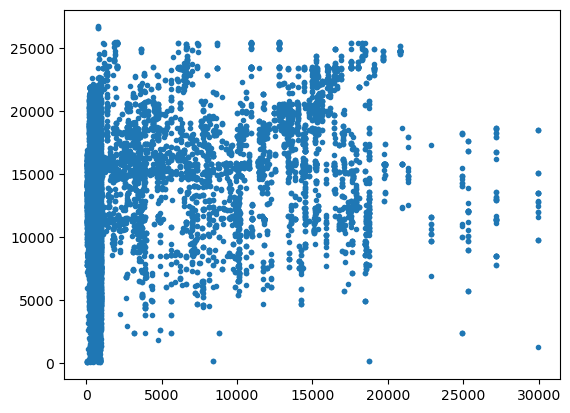

In [16]:
plt.plot(df_test['station_vis'].values,df_test['visi'],'.')
plt.show()

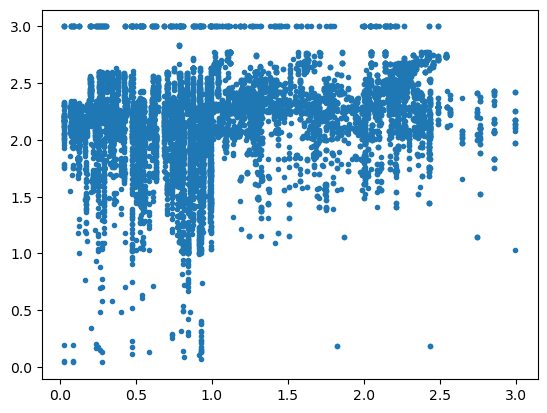

1.526702499673202
相关系数0.23269957328616203, p值为0.00000


In [17]:
plt.plot(df_test['station_vis'].apply(linear_vis),df_test['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_test['station_vis'].apply(linear_vis),df_test['visi'].apply(linear_vis)))
r,p = pearsonr(df_test['station_vis'].apply(linear_vis),df_test['visi'].apply(linear_vis))
print(f'相关系数{r}, p值为{p:.5f}')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 